# Methodology: Machine Learning and Credit Default

#### Thomas Birkner, Tom O'Connell, Theyab Alrashdi

 The data that we use is from the Home Credit dataset on Kaggle. Home Credit is a international consumer finance provider in Europe who focuses on providing loan opportunities for consumers with limited access to traditional banking. The main datasets we will be exploring are application_train and application_test which have been pre split with application_train containing the target feature which is whether or not they will default. The data sets include all of the static data for each loan application at Home Credit.


In [101]:
import pandas as pandas
pandas.set_option('display.max_columns', None)
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

The application_train dataset contains 122 total features and 307511 instances.

In [102]:
#Read in dataset and create dataframe
application_training_df= pandas.read_csv('application_train.csv')
application_testing_df=pandas.read_csv('application_test.csv')
application_training_df.head()

application_training_df.shape

(307511, 122)

The nulls in the data will need to be filled to prepare for machine learning and exploratory data analysis. We have decided to fill all of the numerical features using the median and the categoricals using the most frequent, which takes the value that is the most frequent and fills it in using that.

In [103]:
# Identify numerical and categorical features
numerical_features = application_training_df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = application_training_df.select_dtypes(include=['object']).columns

# Fill missing values for numerical features using simple imputer
numerical_imputer = SimpleImputer(strategy='median') 
application_training_df[numerical_features] = numerical_imputer.fit_transform(application_training_df[numerical_features])

# Fill missing values for categorical features using simple imputer
categorical_imputer = SimpleImputer(strategy='most_frequent')  
application_training_df[categorical_features] = categorical_imputer.fit_transform(application_training_df[categorical_features])


In [104]:
# Identify numerical and categorical features
numerical_features = application_testing_df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = application_testing_df.select_dtypes(include=['object']).columns

# Fill missing values for numerical features using simple imputer
numerical_imputer = SimpleImputer(strategy='median') 
application_testing_df[numerical_features] = numerical_imputer.fit_transform(application_testing_df[numerical_features])

# Fill missing values for categorical features using simple imputer
categorical_imputer = SimpleImputer(strategy='most_frequent')  
application_testing_df[categorical_features] = categorical_imputer.fit_transform(application_testing_df[categorical_features])


The categorcial features need to be transformed to numerical for machine learning, we will use One Hot Encoding to do this.

In [105]:
OHC=OneHotEncoder(handle_unknown='ignore')

#get categorcial features
categorical_features = application_training_df.select_dtypes(include=['object']).columns

# Fit and transform using one hot encoder
encoded_features = OHC.fit_transform(application_training_df[categorical_features]).toarray()

df_encoded = pandas.DataFrame(encoded_features, columns=OHC.get_feature_names_out(categorical_features), index=application_training_df.index)

train_application_df= application_training_df.merge(df_encoded, left_index=True, right_index=True)

# Drop all of orignial categorical features as they will not be needed
train_application_df.drop(categorical_features, axis=1, inplace=True)

train_application_df.shape

(307511, 246)

In [106]:
OHC=OneHotEncoder(handle_unknown='ignore')

#get categorcial features
categorical_features = application_testing_df.select_dtypes(include=['object']).columns

# Fit and transform using one hot encoder
encoded_features = OHC.fit_transform(application_testing_df[categorical_features]).toarray()

df_encoded = pandas.DataFrame(encoded_features, columns=OHC.get_feature_names_out(categorical_features), index=application_testing_df.index)

test_application_df= application_testing_df.merge(df_encoded, left_index=True, right_index=True)

# Drop all of orignial categorical features as they will not be needed
test_application_df.drop(categorical_features, axis=1, inplace=True)

test_application_df.shape

(48744, 242)

In [107]:
train_application_df=train_application_df.drop(columns=['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave'])

In [108]:
X_train= train_application_df.drop(columns=['TARGET'])
y_train=train_application_df['TARGET']

X_test= test_application_df

In [109]:
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)

X_train=pandas.DataFrame(X_train)

scaler=StandardScaler()
scaler.fit(X_test)

X_test=scaler.transform(X_test)

X_test=pandas.DataFrame(X_test)

Logistic Regression

In [110]:
# create model and fit to training data
lr_model= LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
#make predictions on training set
y_pred= lr_model.predict(X_train)

#make predictions on test set
y_pred_test=lr_model.predict(X_test)

In [111]:
accuracy= accuracy_score(y_train, y_pred)
precision=precision_score(y_train, y_pred)
recall=recall_score(y_train, y_pred)
f1=f1_score(y_train, y_pred)

print("Accuracy:", accuracy)
print("Precision :", precision)
print("Recall: ", recall)
print("F1 Score:", f1)
pandas.crosstab(y_train,y_pred)

Accuracy: 0.919254920962177
Precision : 0.4959871589085072
Recall:  0.01244712990936556
F1 Score: 0.02428481609556743


col_0,0.0,1.0
TARGET,,
0.0,282372,314
1.0,24516,309


In [112]:
import numpy as np
def plot_roc(y_truth, y_prob, ax):

    from sklearn.metrics import roc_curve

    FPR, TPR, thresholds = roc_curve(y_truth, y_prob)

    ax.step(FPR, TPR, linewidth=2)
    ax.plot([0,1], [0,1], '--', color = 'black')

    fs = 12
    ax.set_xlabel('1 - Specifity = 1 - TNR = FPR', fontsize=fs)
    ax.set_ylabel('Sensitivity = TPR', fontsize=fs)
    ax.tick_params(axis='both', labelsize=fs)

    AUC = np.trapz(TPR, FPR)
    ax.set_title('ROC Curve, AUC = ' + str(round(AUC,4)))
    
    print('AUC = ' + str(round(AUC,4)))

AUC = 0.7491


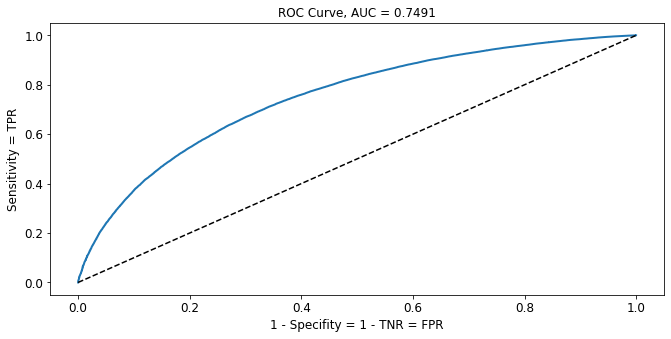

In [113]:
fig1, ax1 = plt.subplots(figsize=(11,5))
plot_roc(1 - y_train, lr_model.predict_proba(X_train)[:,0], ax1)

Random Forest

In [114]:
rforest=RandomForestClassifier(random_state=42)
rforest.fit(X_train, y_train)
y_pred=rforest.predict(X_train)

In [115]:
accuracy= accuracy_score(y_train, y_pred)
precision=precision_score(y_train, y_pred)
recall=recall_score(y_train, y_pred)
f1=f1_score(y_train, y_pred)

print("Accuracy:", accuracy)
print("Precision :", precision)
print("Recall: ", recall)
print("F1 Score:", f1)
pandas.crosstab(y_train,y_pred)

Accuracy: 0.9999642289218922
Precision : 1.0
Recall:  0.9995568982880161
F1 Score: 0.9997784000483491


col_0,0.0,1.0
TARGET,,
0.0,282686,0
1.0,11,24814


AUC = 1.0


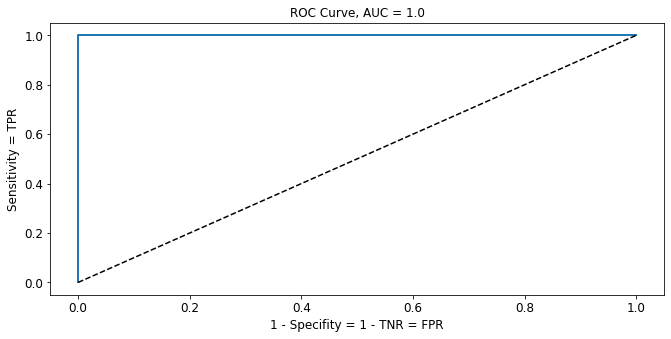

In [116]:
fig1, ax1 = plt.subplots(figsize=(11,5))
plot_roc(1 - y_train, rforest.predict_proba(X_train)[:,0], ax1)

XG Boost

In [117]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)

AUC = 0.8412


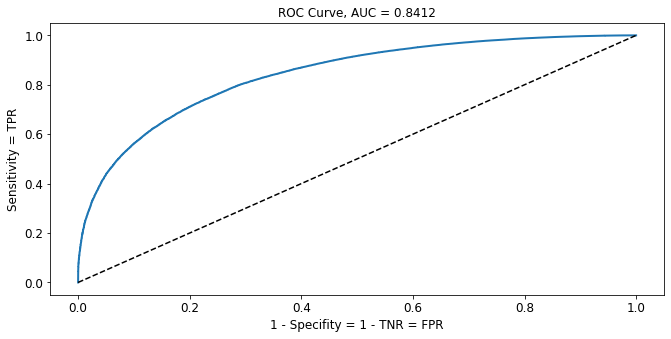

In [118]:
fig1, ax1 = plt.subplots(figsize=(11,5))
plot_roc(1 - y_train, xgb_model.predict_proba(X_train)[:,0], ax1)

In [119]:
accuracy= accuracy_score(y_train, y_pred)
precision=precision_score(y_train, y_pred)
recall=recall_score(y_train, y_pred)
f1=f1_score(y_train, y_pred)

print("Accuracy:", accuracy)
print("Precision :", precision)
print("Recall: ", recall)
print("F1 Score:", f1)
pandas.crosstab(y_train,y_pred)

Accuracy: 0.9229913726663437
Precision : 0.780667320902846
Recall:  0.06408862034239678
F1 Score: 0.11845289059300895


col_0,0,1
TARGET,,
0.0,282239,447
1.0,23234,1591


Naive Bayes

In [120]:
nb_model=GaussianNB()
nb_model.fit(X_train, y_train)
y_pred=nb_model.predict(X_train)

AUC = 0.6285


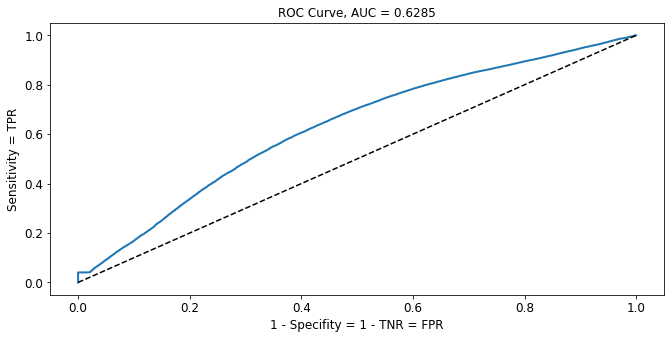

In [121]:
fig1, ax1 = plt.subplots(figsize=(11,5))
plot_roc(1 - y_train, nb_model.predict_proba(X_train)[:,0], ax1)

Accuracy, Precision, and Recall

In [122]:
accuracy= accuracy_score(y_train, y_pred)
precision=precision_score(y_train, y_pred)
recall=recall_score(y_train, y_pred)
f1=f1_score(y_train, y_pred)

print("Accuracy:", accuracy)
print("Precision :", precision)
print("Recall: ", recall)
print("F1 Score:", f1)
pandas.crosstab(y_train,y_pred)

Accuracy: 0.13564392818468282
Precision : 0.08311304564453179
Recall:  0.9676132930513596
F1 Score: 0.15307751377289774


col_0,0.0,1.0
TARGET,,
0.0,17691,264995
1.0,804,24021
